<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 1.

# Load libraries

In [1]:
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from matplotlib import  pyplot as plt
import seaborn as sns
#sns.set()

from time import time as timer
from imageio import imread
import pandas as pd
import numpy as np
import os

from sklearn.manifold import TSNE

import tensorflow as tf
import tarfile

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [2]:
pip install umap-learn

     ---------------------------------------- 0.0/90.8 kB ? eta -:--:--
     ---------------------------------------- 90.8/90.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ------------------ --------------------- 0.5/1.1 MB 10.9 MB/s eta 0:00:01
     ---------------------------------------  1.1/1.1 MB 12.0 MB/s eta 0:00:01
     ---------------------------------------- 1.1/1.1 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86862 sha256=eae32d66a652f65299ea7c9b5ffd8c4fe9c46786df92b66df7140b51805e98df
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\42\7b\35\c53136bf6554719351c45217002d767ed2582664997ed2db43
  Created wheel for pynndescent: filename=pynndesc

In [3]:
import umap

In [4]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

In [5]:
from utils.routines import *

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [6]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [0.44056656] ;  b = -7.631540098469203


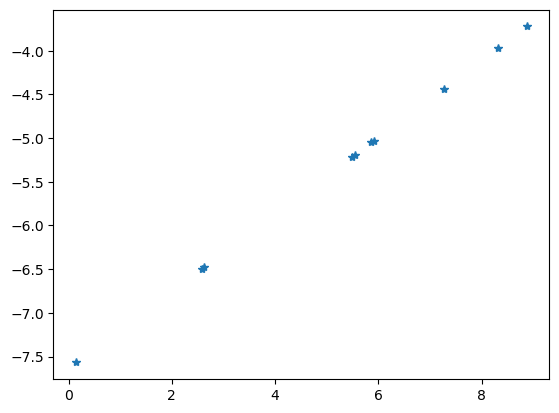

In [7]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')
plt.show()

true slopes: w = [2.8597092  1.82191085] ;  b = 5.0810262888775135


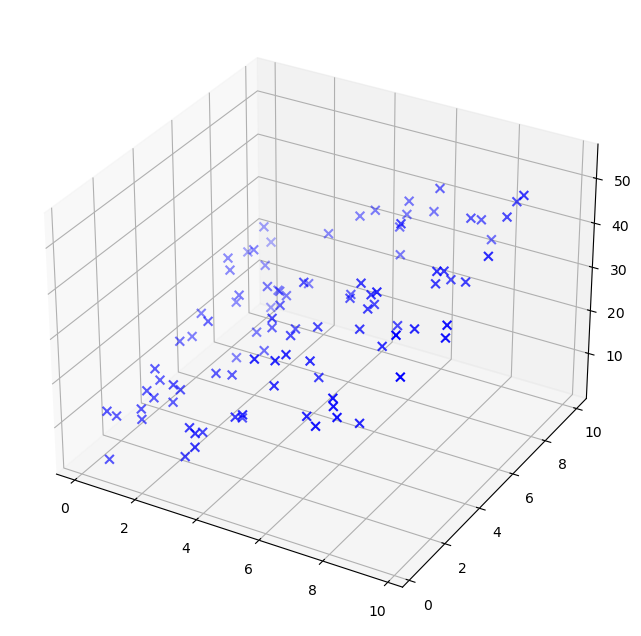

In [8]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)
plt.show()

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [9]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)

In [10]:
def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)

    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)

    return features_scaled

In [11]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


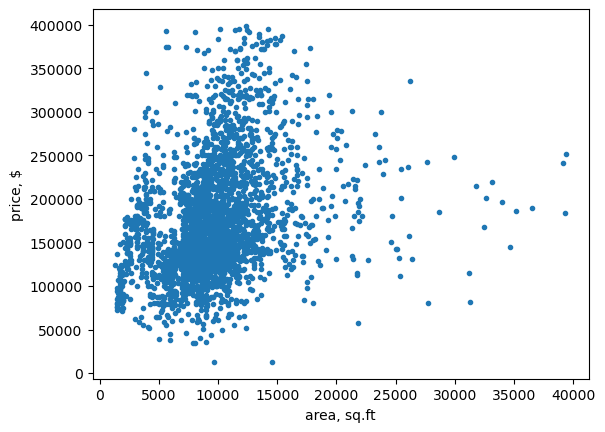

In [12]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');
plt.show()

## 3. Blobs

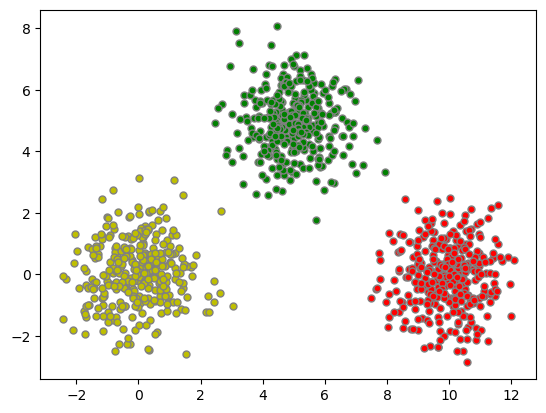

In [13]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)
plt.show()

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [14]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Let's check few samples:

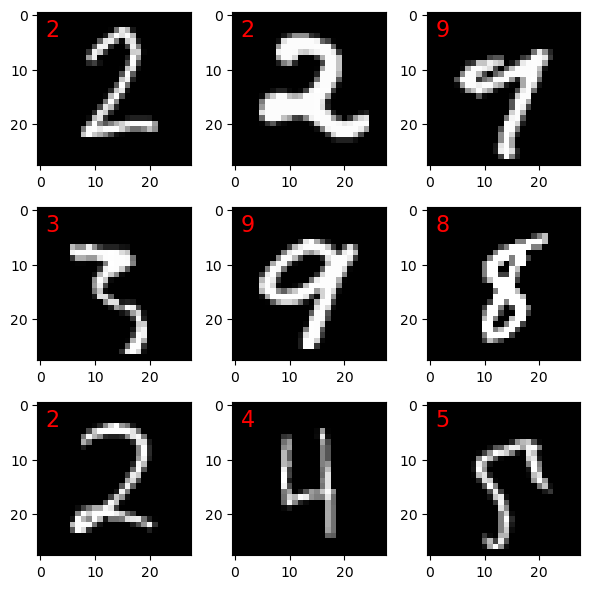

In [16]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()
plt.show()

## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [17]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Let's check few samples:

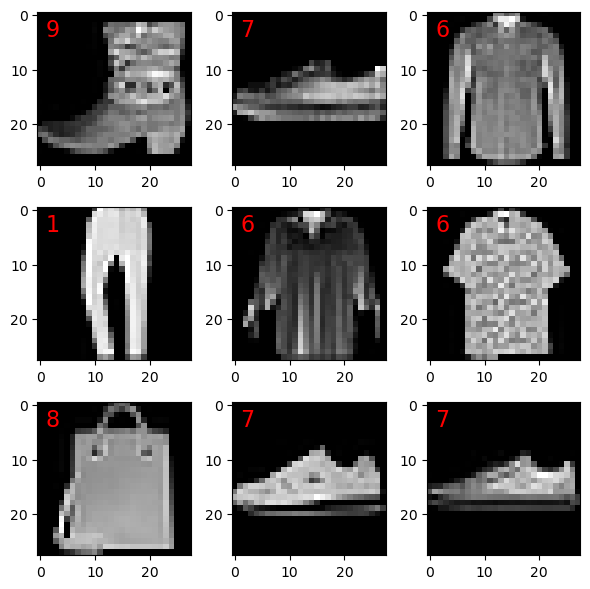

In [19]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()
plt.show()

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

# 1. Unsupervised Learning Techniques


Unsupervised learning technique different from supervised ones from the fact that data are not labelled (no supervision).

We do not aim at fitting a mapping from $X$ to $Y$, but to understand pattern in the data cloud $X$.

## 1. Principal Component Analysis (PCA)

Let's start with the example that we will use to make the theory more concrete. We will take a dataset from from kaggle https://www.kaggle.com/datasets/miroslavsabo/young-people-survey?resource=download (already downloaded for you in the folder `data`)

The datasets consists of the results of a survey about the music preferences of several students, arriving at the following dataset:

In [20]:
data=pd.read_csv("data/responses.csv")

In [21]:
data

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,5.0,2.0,5.0,2.0,2.0,5.0,4.0,4.0,4.0,3.0,...,20.0,164.0,57.0,1.0,female,right handed,secondary school,no,city,house/bungalow
1006,4.0,4.0,5.0,1.0,3.0,4.0,1.0,4.0,1.0,1.0,...,27.0,183.0,80.0,5.0,male,left handed,masters degree,no,village,house/bungalow
1007,4.0,3.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,1.0,...,18.0,173.0,75.0,0.0,female,right handed,secondary school,yes,city,block of flats
1008,5.0,3.0,3.0,3.0,1.0,3.0,1.0,3.0,4.0,1.0,...,25.0,173.0,58.0,1.0,female,right handed,college/bachelor degree,no,city,block of flats


In [22]:
music_columns=data.columns[:19]
print(music_columns)
music_data=data[music_columns].dropna()

Index(['Music', 'Slow songs or fast songs', 'Dance', 'Folk', 'Country',
       'Classical music', 'Musical', 'Pop', 'Rock', 'Metal or Hardrock',
       'Punk', 'Hiphop, Rap', 'Reggae, Ska', 'Swing, Jazz', 'Rock n roll',
       'Alternative', 'Latino', 'Techno, Trance', 'Opera'],
      dtype='object')


The answers are of course correlated and we expect to have typical patterns recurring, that we define as people liking similar types of songs.

The patterns may be also mixing, for e.g. a class of people may like classic `Pop` and `Reggae`, but not `Latino`. An other class may like `Latino` and `Reggae`, but not `Pop`.

PCA will help to find these typical patterns and their number in a data driven fashion. As we will see these patterns will naturally appear when trying to compress data in a lower dimensional space.

### Theory overview.

We will look at PCA from the point of view of `dimensionaliy reduction`.

**Objective:** PCA is used for dimensionality reduction when we have a large number $D$ of features with non-trivial intercorrelation ( data redundancy ) and to isolate relevant features. The number of features $D$ defines the original dimension of the dataset. Each sample defines a vector of dimensionality $D$.


    QUESTION: what are the starting vectors in our survey dataset? How many do we have?

PCA provides a new set of $M$ uncorrelated features for every data point, with $M \le D$. The new features are:

- a linear combination of the original ones ;
- uncorrelated between each other ;

If $M \ll D$ we get an effective dimensionality reduction.

    QUESTION: Does the number of data points changes after applying PCA?

***MOTIVATION***

What do we need from a dimensionality reduction?

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/pca-theory.png" width="100%"/>

***REPRESENTATION***

Each data point indexed by $p=1..N$ starts from an original $D-$dimensional space:
$$x_p=(x_{p,1},...,x_{p,D})$$

We want to find another more economical representation with $M$ components:
$$x'_p=(x_{p,1},...,x_{p,M})$$

PCA does that by defining $D$ auxiliar vectors, called the `principal components` or `principal vectors`:

$$k_1=(k_{1,1},...,k_{1,D})$$
$$...$$
$$k_D=(k_{D,1},...,k_{D,D})$$

$$\mathbf k_{i'} \cdot \mathbf k_{j'} = \delta_{i',j'}$$

such that:

$$x'_{p,i'}=\mathbf x_p \cdot \mathbf k_{i'}, i'=1...D$$

How are these principal components chosen? How can prove that:

$$S^2=\frac{1}{N}\sum_{p=1}^{N}  |\mathbf{x}_p - \mathbf{\overline{x}}|^2=\sum_{i'=1}^{D}\left( \frac{1}{N}\sum_{p=1}^{N}  |x_{p,i'} - \overline{x'}_{i'}|^2\right) $$  
and therefore:

$$S^2=\epsilon_1+\epsilon_2+...+\epsilon_D$$

PCA finds principal vectors $\mathbf k$ such that $\epsilon_1$ is as largest as possible, $\epsilon_2<\epsilon_1$ is such that $\epsilon_1+\epsilon_2$ is as largest as possible, and so on. Therefore truncating the summation the error is as small as possible among all possible choices all $k$-vectors. The $\epsilon$ are called the `explained variance` values.

The ratios:

$$\rho_1=\epsilon_1/S^2,\rho_2=\epsilon_2/S^2,...$$

are called the `explained variance ratio` values, and their cumulated brothers:

$$r_1=\epsilon_1/S^2,r_2=(\epsilon_1+\epsilon_2)/S^2,...,r_D=1$$

is the `cumulated explained variance ratio`.

The number of components is chosen selecting an optimal number of components (M) to keep. The plot of the explained variance ratio as a function of k is called a *scree plot* as serves to select an optimal value of $M$ (if it exists). If $M$ is small we have obtained a new data representation.

NAMES TO REMEMBER:

- `Principal components`: A sequence of orthonormal vectors $k_1,..,k_n$. We can interpret these vectors as the typical patterns found in the data, from increasing to decreasing probability of appearance.

- `Scores`: For every sample-point $p$, the new features are called scores are given by the component of $p$ along the $k$ vectors: $$x'_{p,i}=\mathbf x_p \cdot \mathbf k_i$$, sometimes also denoted with the letter $s_{p,i}$.  

- `Explained variance`: For every k, the ratio between the variance of the reconstructed vectors and total variance. The number of components is chosen selecting an optimal k. The plot of the explained variance as a function of k is called a *scree plot*.



***INTERPRETATION: RECONSTRUCTED VECTOR***

The scores can be used to derive a best approximation of the original vector, if needed, using only the first $M$ principal components:

$$\mathbf x_{rec}=\sum_{i=1}^M s_{p,i} \mathbf k_i$$

When doing this operation, PCA acts like a filter to remove noise. This also explains the interpretation of the principal component as a pattern.

    QUESTION:
    What are the main differences between a vector $x_p$ and a principal component $k_n$? In particular:
    1) how many do we have ? 
    2) what are their dimensions ?
    
    QUESTION:
    What are the differences between $x_p$ and a score vector $s_p$? In particular:
    1) how many do we have ? 
    2) what are their dimensions ?
    
    QUESTION:
    1) How many reconstructed vectors do we have? What is their dimension ? Can we have a reconstructed vector with zero error?
    

### Sklearn: implementation and usage of PCA.


https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

We start showing a two-dimensional example that can be easy visualized.

We load the datasets that we are going to use for the examples:

We have  30 samples of dimension  2


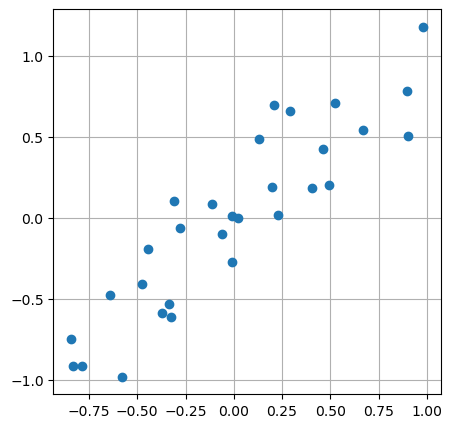

In [23]:
data=load_sample_data_pca()

n_samples,n_dim=data.shape

print('We have ',n_samples, 'samples of dimension ', n_dim)

plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')
plt.show()

The data set is almost one dimensional. PCA will confirm this result.

As with most of sklearn functionalities, we need first to create a PCA object. We will use the object methods to perform PCA.

In [24]:
pca=PCA(n_components=2)

A call to the pca.fit method computes the principal components

In [25]:
pca.fit(data)

PCA(n_components=2)

Now the pca.components_ attribute contains the principal components. We can print them alongside with the data and check that they constitute an orthonormal basis.

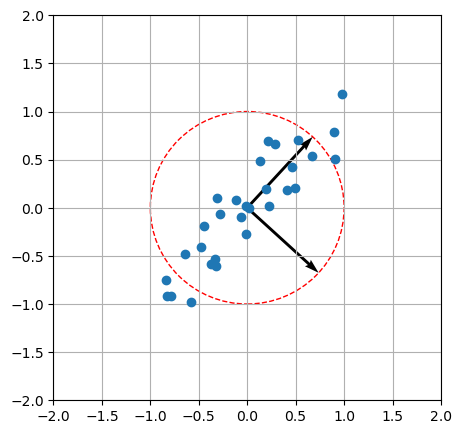

In [26]:
plt.figure(figsize=((5,5)))
plt.grid()
plt.plot(data[:,0],data[:,1],'o')

circle=plt.Circle((0, 0), 1.0, linestyle='--', color='red',fill=False)
ax=plt.gca()
ax.add_artist(circle)

for vec in pca.components_:
    plt.quiver([0], [0], [vec[0]], [vec[1]], angles='xy', scale_units='xy', scale=1)

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

The pca.explained_variance_ratio_ attribute contains the explained variance. In this case we see that already the first reconstructed vector explains 95% of the variance.

In [27]:
print(pca.explained_variance_ratio_) #r1, r2

[0.95140729 0.04859271]


To compute the reconstructed vectors for k=1 we first need to compute the scores and then multiply by the basis vectors:

$$\mathbf x_{rec}=\sum_{i<M} (\mathbf x \cdot \mathbf k_i) \mathbf k_i$$

In [28]:
k=1
scores=pca.transform(data)
res=np.dot(scores[:,:k], pca.components_[:k,:] )

C:\Users\User\AppData\Local\Temp\ipykernel_18884\1393811091.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')


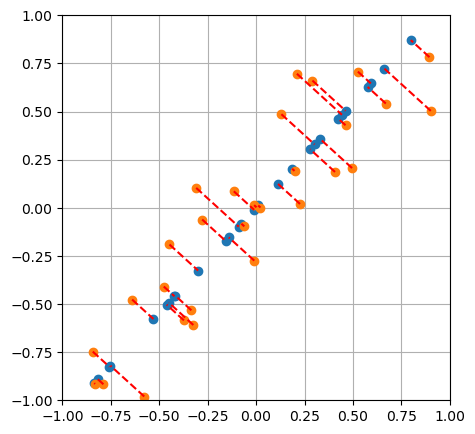

In [29]:
plt.figure(figsize=((5,5)))
plt.plot(res[:,0],res[:,1],'o')
plt.plot(data[:,0],data[:,1],'o')

for a,b,c,d in zip(data[:,0],data[:,1],res[:,0],res[:,1]) :
    plt.plot([a,c],[b,d],'-', linestyle = '--', color='red')

plt.grid()

plt.xlim(-1.0,1.0)
plt.ylim(-1.0,1.0)
plt.show()

The same procedure is followed for high dimensional datasets. Here we generate random data which lies almost on a 6-dimensional subspace. The resulting scree plot can be used to find this result in a semi-automatic fashion.

Let's redo the same now with our survey dataset, to review the concepts again and think "high"-dimensionally.

In [30]:
pca=PCA()
pca.fit(music_data)

PCA()

In [31]:
music_data.shape

(931, 19)

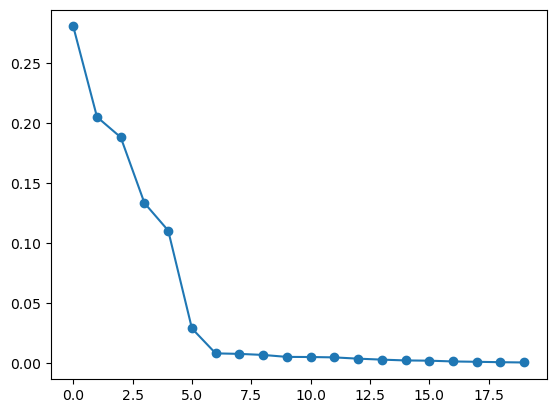

In [57]:
plt.plot(pca.explained_variance_ratio_,'-o')

In [33]:
df = pd.DataFrame(pca.components_.transpose(),
                  columns = [f'V_{i+1}' for i in range(len(music_columns))],
                  index=music_columns)
df

,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,V_10,V_11,V_12,V_13,V_14,V_15,V_16,V_17,V_18,V_19
Music,0.034327,-0.030242,-0.058575,0.003401,-0.005648,0.070442,-0.072589,0.046377,-0.002965,-0.044203,0.005060,-0.112661,0.011120,0.114572,0.140985,-0.138319,-0.223307,0.223824,-0.902855
Slow songs or fast songs,-0.038844,0.001008,-0.150553,0.058194,-0.098439,0.037892,0.008159,-0.023107,-0.106553,0.048223,0.046499,-0.469155,-0.196216,0.302002,0.408006,-0.491768,0.244483,0.258269,0.245515
Dance,-0.108185,-0.351080,-0.242687,0.144840,-0.215340,0.140691,0.072253,0.150583,-0.106101,-0.007872,-0.225787,-0.284248,-0.454947,-0.441326,0.126784,0.223653,-0.171112,-0.224983,-0.016402
Folk,0.198776,-0.190829,0.165786,0.110605,-0.005172,-0.214301,0.350442,0.290317,-0.367466,-0.340010,-0.047813,-0.350712,0.189948,0.291911,-0.329439,0.068718,-0.136498,-0.024515,0.040103
Country,0.170824,-0.140712,0.074469,0.013157,-0.127616,-0.205966,0.493252,0.371091,0.024814,0.188480,0.321041,0.317403,0.049683,-0.341773,0.253690,-0.175941,0.060453,0.217247,-0.013842
Classical music,0.321165,-0.154089,0.246121,0.335864,0.050521,-0.112244,-0.242079,0.058894,0.227351,-0.237305,-0.084052,0.144460,-0.040855,0.015306,0.203028,-0.416664,-0.063652,-0.515503,-0.006618
Musical,0.195235,-0.315976,0.227786,-0.189421,-0.212367,-0.041638,-0.419096,-0.113744,-0.242206,0.473885,0.297234,-0.237463,0.195298,-0.144131,-0.132668,-0.080119,-0.153356,-0.055279,0.037238
Pop,-0.102153,-0.323553,-0.093759,-0.191536,-0.354285,0.196396,-0.257379,0.313967,0.084972,-0.267280,-0.222586,0.120422,0.331245,-0.039526,-0.088276,-0.056829,0.484205,0.097763,-0.038331
Rock,0.307950,0.116657,-0.196066,-0.138037,-0.298001,0.155711,-0.095854,0.090328,0.178293,-0.158085,-0.070379,0.057146,0.217821,0.127137,0.302390,0.159884,-0.586401,0.189754,0.279609
Metal or Hardrock,0.337369,0.277790,-0.224637,0.107211,-0.356716,-0.218770,0.118212,-0.386633,0.140126,-0.183835,0.168455,-0.283392,0.181362,-0.251764,-0.013434,0.139735,0.303840,-0.133485,-0.142317


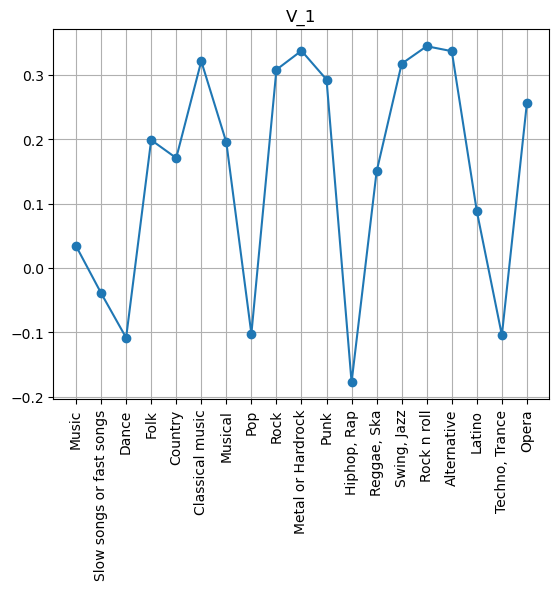

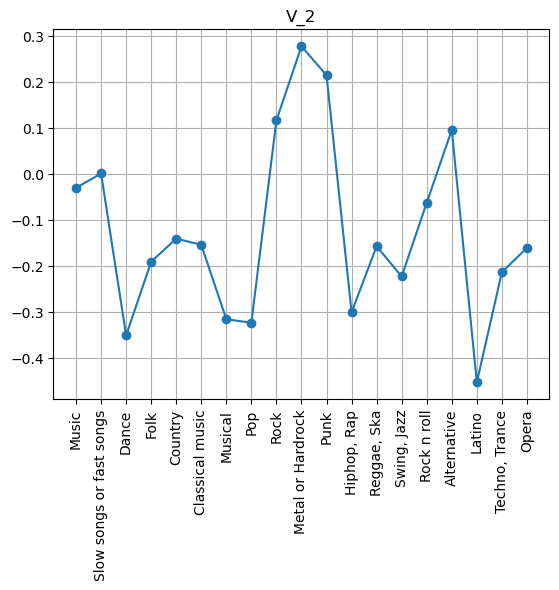

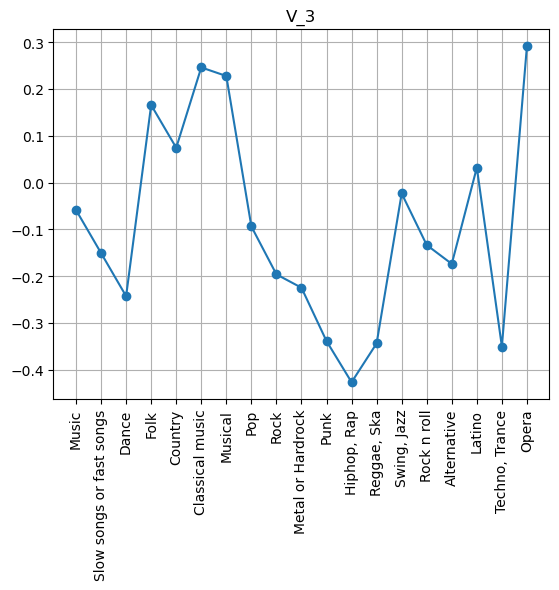

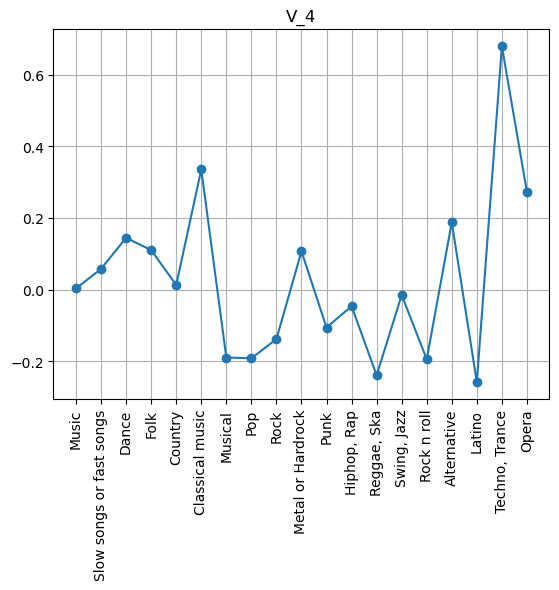

In [34]:
for vector in ['V_1','V_2','V_3','V_4']:
    plt.figure()
    plt.title(vector)
    plt.plot(np.arange(len(music_columns)),list(df[vector]),'-o')
    _=plt.xticks(np.arange(len(music_columns)),music_columns, rotation=90)
    plt.grid()

### EXERCISE 1 : Find the dimensionality of the hidden dataset.

In [72]:
# In this exercise you will take a custom high dimensional dataset and try to find its dimensionality.

# STORY: you suppose you have 20 sensors measuring blood pressure in different parts of the bad during the day,
# reporting measurments every second.
#
# We assume that some particular movements of the body will produce a correlated response in blood pressure.
# Furthermore, these body movements do not happen independently but are superposing each other,
#so that the final pressure measured is a sum of all of them.
#
# You are given a dataset of recording. Your task is to use PCA to discover, under these assumptions,
# how many are the body movements producing these resposes, and to characterize the blood pressure response along these 20 sensors.

# To do that:

# 1. Load the data using the function data=load_multidimensional_data_pca() , check the dimensionality of the data and plot them.
data=load_multidimensional_data_pca()
n_samples,n_dim=data.shape
labels_sensor = np.arange(1,21,1)


print('We have ',n_samples, 'samples of dimension ', n_dim)
for i in range(n_samples):

    plt.plot(data[i],labels_sensor,'ok')
    plt.title(i+1)
    plt.close()
    
print(data[0].shape)

We have  40 samples of dimension  20
(20,)


[0.32522342 0.18712068 0.14511097 0.10659143 0.08678923 0.06470984
 0.01339669 0.01173622 0.01024122 0.00924638 0.00776658 0.00662497
 0.00582983 0.00445439 0.00394859 0.00361134 0.00255692 0.00225732
 0.00182424 0.00095974]


,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,V_10,V_11,V_12,V_13,V_14,V_15,V_16,V_17,V_18,V_19,V_20
1,0.273313,-0.387678,-0.073133,0.018330,0.212222,0.349667,-0.017653,0.088132,-0.216373,0.489081,0.039272,0.049232,0.396142,-0.029416,-0.042727,-0.197452,-0.306149,-0.042721,0.076220,0.063132
2,0.394624,-0.225391,0.138497,0.056182,0.272324,-0.213305,0.045895,-0.230083,0.354168,0.282215,-0.259659,0.055612,-0.304814,-0.115243,0.162944,0.354450,-0.047028,0.175311,-0.061031,-0.160576
3,-0.313540,-0.204352,0.194497,0.047249,-0.074680,-0.090873,0.017805,0.122074,0.101473,0.453579,0.220942,0.015492,-0.343791,0.189178,-0.281112,-0.355525,0.177919,0.058527,-0.265325,-0.246679
4,-0.294826,-0.083647,-0.232673,0.079311,0.013374,0.160573,0.002417,-0.577953,0.270407,0.010787,-0.015045,-0.356702,0.286131,-0.089936,0.021101,-0.151086,0.121988,0.200177,0.168143,-0.297493
5,0.037687,-0.043292,-0.527601,-0.169245,0.275419,-0.352631,-0.268979,0.122660,0.024309,-0.047827,0.231580,-0.167286,0.020644,-0.084981,-0.277913,0.165015,-0.132030,-0.302475,-0.154335,-0.269726
6,0.065462,-0.314127,-0.236490,0.002370,-0.354801,-0.333846,0.341883,0.016776,-0.221332,-0.023153,0.221496,0.037155,-0.161274,-0.042481,0.431554,-0.136834,-0.112394,-0.029367,0.313119,-0.205727
7,-0.199510,-0.130559,-0.200037,0.414907,0.336817,0.199659,-0.196030,0.151148,0.196772,-0.187087,0.341174,0.339410,-0.216419,0.075794,0.091601,0.064388,-0.042839,0.226688,0.282286,0.114273
8,0.138679,0.182734,-0.274549,0.113990,-0.247606,0.137000,-0.326653,-0.320441,-0.185421,0.110843,0.104841,-0.113077,-0.276367,0.226052,0.222942,-0.039183,-0.298768,0.175883,-0.414796,0.167718
9,-0.038889,0.125843,0.015820,-0.500966,0.132323,0.285198,-0.122363,0.068164,-0.245586,0.010084,0.162217,0.227345,-0.066178,-0.347924,0.250905,0.046774,0.196858,0.317302,-0.123074,-0.359723
10,0.143909,-0.028268,-0.210946,-0.275182,-0.457539,0.107656,-0.416485,0.183499,0.307644,0.105318,-0.294312,0.155354,-0.081366,0.120228,-0.163056,-0.049446,0.028346,0.078116,0.389620,-0.069981


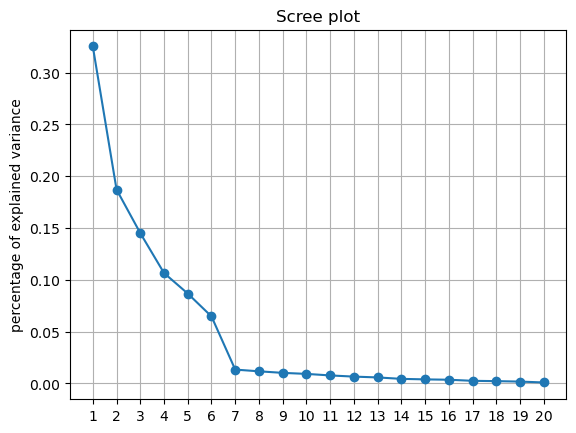

In [73]:
# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca.fit(data)

# 3. Check the explained variance ratio and select best number of components. How many are the typical body movements?
print(pca.explained_variance_ratio_)
plt.plot([str(i) for i in range(1,len(pca.explained_variance_ratio_)+1)],pca.explained_variance_ratio_,'-o')
plt.grid()
plt.title('Scree plot')
plt.ylabel('percentage of explained variance')

df = pd.DataFrame(pca.components_.transpose(),
                  columns = [f'V_{i+1}' for i in range(len(pca.explained_variance_ratio_))],
                  index=labels_sensor)
df

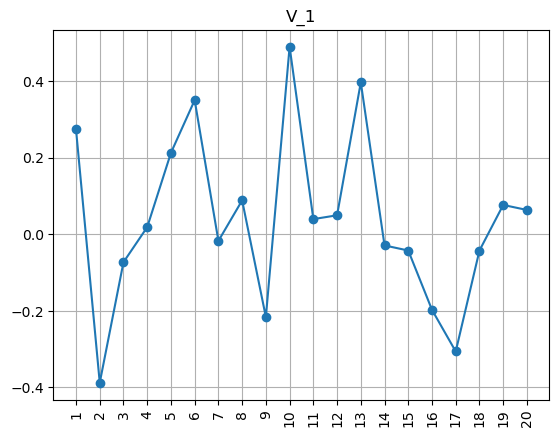

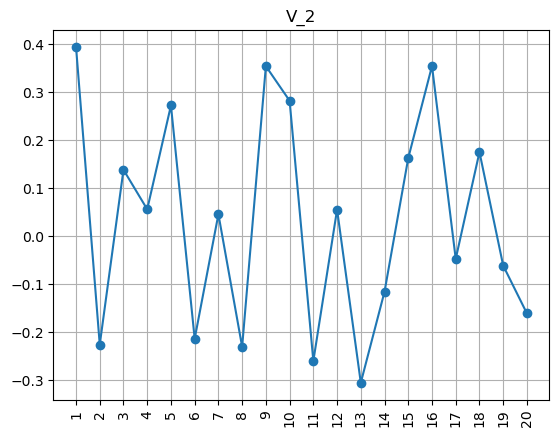

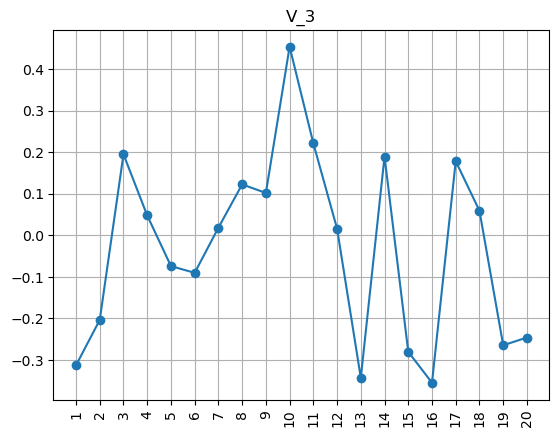

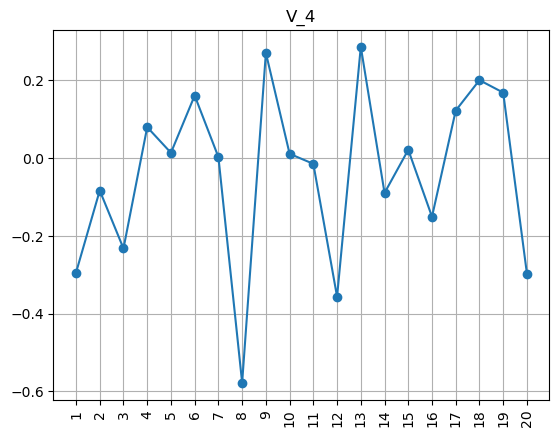

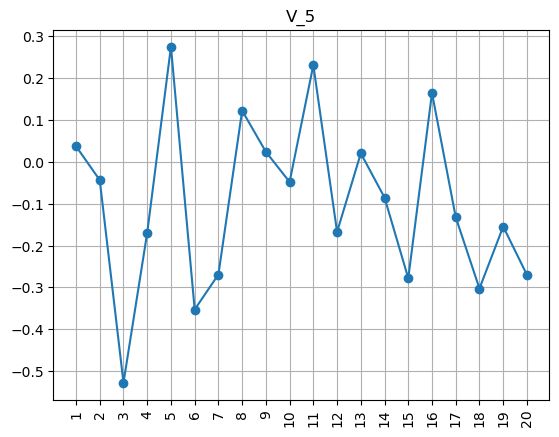

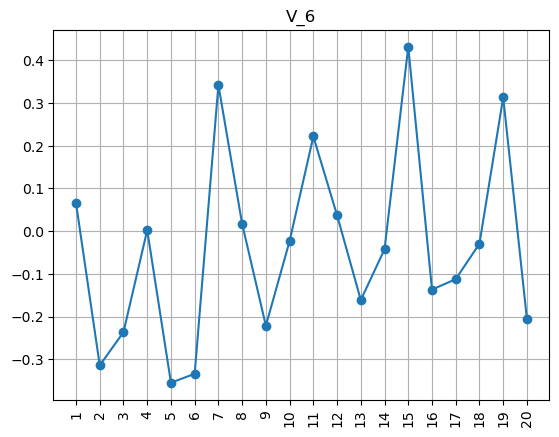

In [74]:
# 3. Plot the pattern response associated to the typical body movements by exploring the principal vectors.
for i in range(len(pca.components_[0:6])):
    plt.figure()
    plt.title(f'V_{i+1}')
    plt.plot(np.arange(len(labels_sensor)),pca.components_[:,i],'-o')
    plt.xticks(np.arange(len(labels_sensor)),labels_sensor, rotation=90)
    plt.grid()

### EXERCISE 2 : Find the hidden drawing.

In [75]:
### In this exercise you will take a high dimensional dataset, find the optimal number of principal components
# and see what plot do we get if we visualize in a 2D plot the first two scores.

#
## STORY: there is a man of a parallel universe where strings generated a very high dimensional space
#instead of our 3D one. He wants to communicate with you making a drawing that you can access as a set of
#points in a multidimensional letter, given to you as a numpy array. The guy tried to do hist best to communicate
#with you. He cannot write in a 2D space, but he can write on a 2-D subspace of this multidimensional one.
#Mathematically he can link in a subspace generated by the multidimensional vectors k1 and k2, such a subspace
#is the subset of points s1 * k_1 + s_2 * k_2 .

# Can you decode the message?
#

# 1. Load the data using the function data=load_ex2_data_pca(seed=1235) , check the dimensionality of the data to
#get a feeling of how high dimensional this letter is.
data=load_ex2_data_pca(seed=1235)
n_samples,n_dim=data.shape
print('We have ',n_samples, 'samples of dimension ', n_dim)

We have  961 samples of dimension  10


Explained variance ratio:  [0.79700994 0.15407412 0.00688753 0.00667879 0.00652795 0.00605738
 0.00596107 0.00576693 0.00561825 0.00541804]


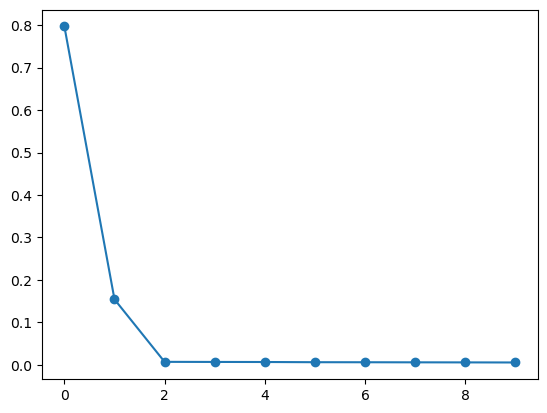

In [76]:
# 2. Define a PCA object and perform the PCA fitting.
pca=PCA()
pca.fit(data)

# 3. Check the explained variance ratio and select best number of components. Did the guy do a good job?
print('Explained variance ratio: ' ,pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_,'-o')

In [ ]:
# 4. Try to plot the first score against the second one, for each of the data point. What does the alien want to tell you?
k=...
data_transformed=...
plt.plot(data_transformed[:,...],data_transformed[:,...],'o')
plt.xlabel('First component')
plt.ylabel('Second component')

### EXERCISE 3 (bonus) :

In [ ]:
# Explore more the survey dataset. Suppose you have studied the first vectors and found
# some 4 types of music advertisment, targetted to the 4 classes of clients.

# Given a customer, how would you choose which advertisement to send him?

### Final comments:

PCA is able therefore to make this mapping:

$(x_1,...,x_D) \rightarrow (y_1,..,y_M)$

Here we focused on data compression, but it is also very important that $y_1,...,y_M$ are uncorrolated for interpratibility purposes. Being uncorrelated means (roughly) that in our dataset we can change one variable without affecting the others. The dimensions 1,...,M are often therefore more interpretable and providing more information.

See e.g. a similar application here:

"Principal component analysis of dietary and lifestyle patterns in relation to risk of subtypes of esophageal and gastric cancer", https://pubmed.ncbi.nlm.nih.gov/21435900/

, where each data point $x$ is an answer from a questionnaire of food. The principal components are than typical "patterns" of answers that are uncorrlated, have a look at table 2, and if you want read the whole data story :)

## 2. Data visualization and embedding in low dimensions ( t-SNE / UMAP )

### Theory overview

PCA is a linear embedding technique where the scores are a linear function of the original variables. This forces the number of principal components to be used to be high, if the manifold is highly non-linear. Curved manifolds need to be embedded in higher dimensions.

Other `non-linear` embedding techniques start from a local description of the environment of each sample point in the original space:

- `t-Sne` uses a `statistical description` of the environment of a sample point ;
- `UMAP` describes the `topology` of the environment through a generalized "triangulation" (simplex decomposition) ;

The projection on the low-dimensional space is optimized in order to match as much as possible the description of the local environment.

It is not the goal of this introduction to discuss the derivation of such approaches, which can be found in the references:

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

https://arxiv.org/pdf/1802.03426.pdf



Instead, the following, we will show how to apply practically these dimensionality reductions techniques. Keep in mind that the embedding is given by an iterative solution of a minimization problem and therefore the results may depend on the value of the random seed, especially for t-SNE visualizazions.

### Utilization in Python and examples

To begin with, we create a t-SNE object that we are going to use.

In [ ]:
tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca',
                      n_iter=2000, random_state=2233212, metric='euclidean', verbose=100 )

umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

### Example 1: Exercise 3 Cont'd

We will first visualize our multi-dimensional heart using t-SNE:

In [ ]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca',
                      n_iter=300, random_state=2233212, metric='euclidean', verbose=1 )

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.001s...
[t-SNE] Computed neighbors for 651 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.060286


/home/arismarcolongo/miniconda3/envs/selective_search/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 10.369261
[t-SNE] KL divergence after 300 iterations: 0.602112


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from utils.routines import *
import matplotlib.pyplot as plt

X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3, verbose=1).fit_transform(X)
X_embedded.shape

[t-SNE] Computing 3 nearest neighbors...
[t-SNE] Indexed 4 samples in 0.000s...
[t-SNE] Computed neighbors for 4 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 4 / 4
[t-SNE] Mean sigma: 12.094863
[t-SNE] KL divergence after 250 iterations with early exaggeration: 33.738800
[t-SNE] KL divergence after 1000 iterations: 0.047805


(4, 2)

In [ ]:
data= load_ex2_data_pca(seed=1235, n_add=20)

tsne_model = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=1)

tsne_heart = tsne_model.fit_transform(data)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 651 samples in 0.001s...
[t-SNE] Computed neighbors for 651 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 651 / 651
[t-SNE] Mean sigma: 0.025506
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.112373
[t-SNE] KL divergence after 1000 iterations: 0.924472


In [ ]:
plt.scatter(tsne_heart[:,0],tsne_heart[:,1])
plt.show()

And using UMAP :

In [ ]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)

umap_hart = umap_model.fit_transform(data)
plt.scatter(umap_hart[:, 0], umap_hart[:, 1])
plt.show()

### Example 2: Mnist dataset

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=10, n_components=2, learning_rate=200,
#                   early_exaggeration=4.0,init='pca',
#                   n_iter=2000, random_state=2233212,
#                   metric='euclidean', verbose=100, n_jobs=1)

# tsne_mnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_mnist[:,0],tsne_mnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_mnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/mnist.png" width="100%"/> |
 |  -----:| -----:|

In [ ]:
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(data)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=labels, s=10)
plt.show()

### Example 3: Fashion_Mnist dataset

In [ ]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=50, n_components=2, learning_rate=200, early_exaggeration=4.0,init='pca',
#                      n_iter=1000, random_state=2233212, metric='euclidean', verbose=100 )

# tsne_fmnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_fmnist[:,0],tsne_fmnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_fmnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/fmnist.png" width="100%"/>
 |  -----:| -----:|

In [ ]:
umap_model = umap.UMAP(n_neighbors=50, n_components=2, random_state=1711)
umap_fmnist = umap_model.fit_transform(data)
plt.scatter(umap_fmnist[:, 0], umap_fmnist[:, 1], c=labels, s=10)
plt.show()

### Example 4: House prices

In [ ]:
data=house_prices_dataset_normed()

In [ ]:
# not to run on COLAB

#tsne_model = TSNE(perplexity=30, n_components=2, learning_rate=200,
#                  early_exaggeration=4.0,init='pca', n_iter=1000,
#                  random_state=2233212, metric='euclidean', verbose=100)

#tsne_houses = tsne_model.fit_transform(data)

#plt.scatter(tsne_houses[:,0],tsne_houses[:,1],s=20)
#plt.savefig('t_sne_houses.png')
# plt.show()

<img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_houses.png" width="50%"/>

In [ ]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)
plt.show()

**Message:** Visualization techniques are useful for having an initial grasp of multi-dimensional datasets and guide further analysis and the choice of the modelling data strategy.

**Caveats:**
- available t-SNE implementations may vary a lot in terms of performance. Computational time can be reduced performing PCA before a t-SNE projection

- UMAP, thanks to the algorithm being amanable to clever initializations and optimization schemes, offers great stability and scaling properties

- UMAP, even if starting from a local picture, is generally more able to spread apart different clusters

- The result of an embedding may depend on the values of the metaparameters. One should try to see how the final embedding changes in order to get to a complete picture